# Term Project3 - DSC680


# TweetSense: Analyzing Public Sentiment on X(Twitter)

#### Author by: Shanthibooshan Subramanian

# Code for Term Project

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import re
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import parallel_backend
import warnings

## Data Preparation

In [2]:
# Define the headers
headers = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content']

# Load the training dataset without headers
train_df = pd.read_csv('twitter_training.csv', header=None)

# Assign the headers to the training dataset
train_df.columns = headers

# Save the training dataset with headers
train_df.to_csv('twitter_training_with_headers.csv', index=False)

# Display the first few rows of both datasets to verify headers have been added correctly
print("Training Dataset with Headers:")
train_df.head()

Training Dataset with Headers:


,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Training dataset from a CSV file that lacks headers and assigns the specified column names. It then saves this updated dataset with the new headers to a new CSV file.

In [3]:
# Load the validation dataset without headers
val_df = pd.read_csv('twitter_validation.csv', header=None)

# Assign the headers to the validation dataset
val_df.columns = headers

# Save the validation dataset with headers
val_df.to_csv('twitter_validation_with_headers.csv', index=False)

print("Validation Dataset with Headers:")
val_df.head()

Validation Dataset with Headers:


,Tweet_ID,Entity,Sentiment,Tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


Validatio dataset from a CSV file that lacks headers and assigns the specified column names. It then saves this updated dataset with the new headers to a new CSV file.

In [4]:
# Display dataset dimensions for training and validation datasets

train_rows, train_columns = train_df.shape
val_rows, val_columns = val_df.shape

print(f"Training Dataset Dimensions: {train_rows} rows, {train_columns} columns")
print(f"Validation Dataset Dimensions: {val_rows} rows, {val_columns} columns")


Training Dataset Dimensions: 74682 rows, 4 columns
Validation Dataset Dimensions: 1000 rows, 4 columns


The training dataset contains 74,682 rows and 4 columns, while the validation dataset includes 1,000 rows and 4 columns.

In [5]:
# Display column names and their data types

print("\nColumn Names and Data Types:")
print(train_df.dtypes)
print(val_df.dtypes)


Column Names and Data Types:
Tweet_ID          int64
Entity           object
Sentiment        object
Tweet_content    object
dtype: object
Tweet_ID          int64
Entity           object
Sentiment        object
Tweet_content    object
dtype: object


In [6]:
# Add a column for tweet length in both training and validation datasets
train_df['Tweet_length'] = train_df['Tweet_content'].str.len()
val_df['Tweet_length'] = val_df['Tweet_content'].str.len()


In [7]:
# Display basic statistics for tweet lengths in the training dataset

print("Tweet length statistics for the training dataset:")
print(train_df['Tweet_length'].describe())

Tweet length statistics for the training dataset:
count    73996.000000
mean       108.783650
std         79.524212
min          1.000000
25%         47.000000
50%         91.000000
75%        153.000000
max        957.000000
Name: Tweet_length, dtype: float64


The training dataset has 73,996 tweets with an average length of 108.8 characters. The tweet lengths vary from 1 to 957 characters. Most tweets are between 47 and 153 characters long, with a standard deviation of 79.5 characters.

In [8]:
# Display basic statistics for tweet lengths in the validation dataset

print("Tweet length statistics for the validation dataset:")
print(val_df['Tweet_length'].describe())

Tweet length statistics for the validation dataset:
count    1000.000000
mean      131.849000
std        81.925429
min         3.000000
25%        67.750000
50%       114.000000
75%       190.250000
max       340.000000
Name: Tweet_length, dtype: float64


The Validation dataset has 1,000 tweets with an average length of 131.8 characters. The lengths range from 3 to 340 characters. Most tweets fall between 67.8 and 190.3 characters, with a standard deviation of 81.9 characters.

In [9]:
# Check for NaN values in the training and validation datasets
print("NaN values in training dataset:")
print(train_df.isna().sum())

print("\nNaN values in validation dataset:")
print(val_df.isna().sum())

NaN values in training dataset:
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
Tweet_length     686
dtype: int64

NaN values in validation dataset:
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
Tweet_length     0
dtype: int64


The training dataset has 686 NaN values in both Tweet_content and Tweet_length. The validation dataset has no NaN values in any columns.

In [10]:
# Check for duplicated rows in the training and validation datasets
print("Duplicated rows in training dataset:")
print(train_df.duplicated().sum())

print("\nDuplicated rows in validation dataset:")
print(val_df.duplicated().sum())

Duplicated rows in training dataset:
2700

Duplicated rows in validation dataset:
0


The training dataset has 2,700 duplicated rows, while the validation dataset has no duplicated rows.

In [11]:
# Remove duplicated rows from the training and validation datasets
train_df = train_df.drop_duplicates()
val_df = val_df.drop_duplicates()

# Remove rows with NaN values from the training and validation datasets
train_df = train_df.dropna()
val_df = val_df.dropna()

# Verify changes
print("\nTraining dataset after removing duplicates and NaN values:")
print(train_df.head())

print("\nValidation dataset after removing duplicates and NaN values:")
print(val_df.head())


Training dataset after removing duplicates and NaN values:
   Tweet_ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet_content  Tweet_length  
0  im getting on borderlands and i will murder yo...          53.0  
1  I am coming to the borders and I will kill you...          51.0  
2  im getting on borderlands and i will kill you ...          50.0  
3  im coming on borderlands and i will murder you...          51.0  
4  im getting on borderlands 2 and i will murder ...          57.0  

Validation dataset after removing duplicates and NaN values:
   Tweet_ID     Entity   Sentiment  \
0      3364   Facebook  Irrelevant   
1       352     Amazon     Neutral   
2      8312  Microsoft    Negative   
3      4371      CS-GO    Negative   
4      4433     Google     Neutral   

      

After removing duplicates and NaN values, the training dataset and validation dataset have been cleaned. The training dataset no longer has duplicated rows or NaN values, and the validation dataset is also free of NaN values and duplicates.

In [12]:
# Ensure 'Tweet_content' column is string and handle NaN values

train_df['Tweet_content'] = train_df['Tweet_content'].astype(str).fillna('')
val_df['Tweet_content'] = val_df['Tweet_content'].astype(str).fillna('')


The Tweet_content column in both the training and validation datasets has been converted to strings and NaN values have been replaced with empty strings.

## Data Cleaning and Preprocessing

In [13]:
# Remove URLs 

train_df['Cleaned_Tweet'] = train_df['Tweet_content'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
val_df['Cleaned_Tweet'] = val_df['Tweet_content'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))

print("\nAfter removing URLs (Training):")
print(train_df[['Tweet_content', 'Cleaned_Tweet']].head())

print("\nAfter removing URLs (Validation):")
print(val_df[['Tweet_content', 'Cleaned_Tweet']].head())


After removing URLs (Training):
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                       Cleaned_Tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

After removing URLs (Validation):
                                       Tweet_content  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News - Amazon boss Jeff Bezos rejects clai...   
2  @Microsoft Why do I pay for WORD when it funct...   
3  CSGO matchmaking is so full of closet 

In the training and validation datasets, URLs have been removed from the Tweet_content column. The Cleaned_Tweet column now contains tweets without URLs.

In [14]:
# Remove mentions and hashtags

train_df['Cleaned_Tweet'] = train_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'@\w+', '', x))
train_df['Cleaned_Tweet'] = train_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'#\w+', '', x))
val_df['Cleaned_Tweet'] = val_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'@\w+', '', x))
val_df['Cleaned_Tweet'] = val_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'#\w+', '', x))

print("\nAfter removing mentions and hashtags (Training):")
print(train_df[['Tweet_content', 'Cleaned_Tweet']].head())

print("\nAfter removing mentions and hashtags (Validation):")
print(val_df[['Tweet_content', 'Cleaned_Tweet']].head())



After removing mentions and hashtags (Training):
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                       Cleaned_Tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

After removing mentions and hashtags (Validation):
                                       Tweet_content  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News - Amazon boss Jeff Bezos rejects clai...   
2  @Microsoft Why do I pay for WORD when it funct...   
3  CSGO

Mentions and hashtags have been removed from the Cleaned_Tweet column in both the training and validation datasets. The updated Cleaned_Tweet column now excludes these elements.

In [15]:
# Remove non-alphabetic characters

train_df['Cleaned_Tweet'] = train_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'\d+', '', x))
train_df['Cleaned_Tweet'] = train_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
val_df['Cleaned_Tweet'] = val_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'\d+', '', x))
val_df['Cleaned_Tweet'] = val_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

print("\nAfter removing non-alphabetic characters (Training):")
print(train_df[['Tweet_content', 'Cleaned_Tweet']].head())

print("\nAfter removing non-alphabetic characters (Validation):")
print(val_df[['Tweet_content', 'Cleaned_Tweet']].head())


After removing non-alphabetic characters (Training):
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                       Cleaned_Tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you all  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands  and i will murder y...  

After removing non-alphabetic characters (Validation):
                                       Tweet_content  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News - Amazon boss Jeff Bezos rejects clai...   
2  @Microsoft Why do I pay for WORD when it funct...   

Non-alphabetic characters have been removed from the Cleaned_Tweet column in both the training and validation datasets. The updated Cleaned_Tweet column now contains only alphabetic characters and spaces.

In [16]:
# Tokenization
train_df['Tokens'] = train_df['Cleaned_Tweet'].apply(word_tokenize)
val_df['Tokens'] = val_df['Cleaned_Tweet'].apply(word_tokenize)

print("\nAfter tokenization (Training):")
print(train_df[['Cleaned_Tweet', 'Tokens']].head())

print("\nAfter tokenization (Validation):")
print(val_df[['Cleaned_Tweet', 'Tokens']].head())


After tokenization (Training):
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                                              Tokens  
0  [im, getting, on, borderlands, and, i, will, m...  
1  [I, am, coming, to, the, borders, and, I, will...  
2  [im, getting, on, borderlands, and, i, will, k...  
3  [im, coming, on, borderlands, and, i, will, mu...  
4  [im, getting, on, borderlands, and, i, will, m...  

After tokenization (Validation):
                                       Cleaned_Tweet  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News  Amazon boss Jeff Bezos rejects claim...   
2   Why do I pay for WORD when it functions so po...   
3  CSGO matchmaking is so full of closet ha

The Cleaned_Tweet column has been tokenized in both the training and validation datasets. The Tokens column now contains lists of individual words for each tweet.

In [17]:
# Lowercase normalization
train_df['Tokens'] = train_df['Tokens'].apply(lambda x: [word.lower() for word in x])
val_df['Tokens'] = val_df['Tokens'].apply(lambda x: [word.lower() for word in x])

print("\nAfter lowercase normalization (Training):")
print(train_df[['Cleaned_Tweet', 'Tokens']].head())

print("\nAfter lowercase normalization (Validation):")
print(val_df[['Cleaned_Tweet', 'Tokens']].head())


After lowercase normalization (Training):
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                                              Tokens  
0  [im, getting, on, borderlands, and, i, will, m...  
1  [i, am, coming, to, the, borders, and, i, will...  
2  [im, getting, on, borderlands, and, i, will, k...  
3  [im, coming, on, borderlands, and, i, will, mu...  
4  [im, getting, on, borderlands, and, i, will, m...  

After lowercase normalization (Validation):
                                       Cleaned_Tweet  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News  Amazon boss Jeff Bezos rejects claim...   
2   Why do I pay for WORD when it functions so po...   
3  CSGO matchmaking i

The tokens in the Tokens column have been converted to lowercase in both the training and validation datasets. The updated Tokens column now contains all lowercase words.

In [18]:
# Remove stopwords

stop_words = set(stopwords.words('english'))
train_df['Tokens'] = train_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])
val_df['Tokens'] = val_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

print("\nAfter removing stopwords (Training):")
print(train_df[['Cleaned_Tweet', 'Tokens']].head())

print("\nAfter removing stopwords (Validation):")
print(val_df[['Cleaned_Tweet', 'Tokens']].head())


After removing stopwords (Training):
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                               Tokens  
0  [im, getting, borderlands, murder]  
1             [coming, borders, kill]  
2    [im, getting, borderlands, kill]  
3   [im, coming, borderlands, murder]  
4  [im, getting, borderlands, murder]  

After removing stopwords (Validation):
                                       Cleaned_Tweet  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News  Amazon boss Jeff Bezos rejects claim...   
2   Why do I pay for WORD when it functions so po...   
3  CSGO matchmaking is so full of closet hacking ...   
4  Now the President is slapping Americans in the...   

        

Stopwords have been removed from the Tokens column in both the training and validation datasets. The updated Tokens column now contains only meaningful words, excluding common stopwords.

In [19]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
train_df['Tokens'] = train_df['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
val_df['Tokens'] = val_df['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

print("\nAfter lemmatization (Training):")
print(train_df[['Cleaned_Tweet', 'Tokens']].head())

print("\nAfter lemmatization (Validation):")
print(val_df[['Cleaned_Tweet', 'Tokens']].head())


After lemmatization (Training):
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                              Tokens  
0  [im, getting, borderland, murder]  
1             [coming, border, kill]  
2    [im, getting, borderland, kill]  
3   [im, coming, borderland, murder]  
4  [im, getting, borderland, murder]  

After lemmatization (Validation):
                                       Cleaned_Tweet  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News  Amazon boss Jeff Bezos rejects claim...   
2   Why do I pay for WORD when it functions so po...   
3  CSGO matchmaking is so full of closet hacking ...   
4  Now the President is slapping Americans in the...   

                        

Lemmatization has been applied to the Tokens column in both the training and validation datasets. The Tokens column now contains words in their base or root form.

In [20]:
# Remove short words
train_df['Tokens'] = train_df['Tokens'].apply(lambda x: [word for word in x if len(word) > 2])
val_df['Tokens'] = val_df['Tokens'].apply(lambda x: [word for word in x if len(word) > 2])

print("\nAfter removing short words (Training):")
print(train_df[['Cleaned_Tweet', 'Tokens']].head())

print("\nAfter removing short words (Validation):")
print(val_df[['Cleaned_Tweet', 'Tokens']].head())


After removing short words (Training):
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                          Tokens  
0  [getting, borderland, murder]  
1         [coming, border, kill]  
2    [getting, borderland, kill]  
3   [coming, borderland, murder]  
4  [getting, borderland, murder]  

After removing short words (Validation):
                                       Cleaned_Tweet  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News  Amazon boss Jeff Bezos rejects claim...   
2   Why do I pay for WORD when it functions so po...   
3  CSGO matchmaking is so full of closet hacking ...   
4  Now the President is slapping Americans in the...   

                                  

Short words with fewer than three characters have been removed from the Tokens column in both the training and validation datasets. The Tokens column now contains only longer, more meaningful words.

In [21]:
# Join tokens back into a string

train_df['Cleaned_Tweet'] = train_df['Tokens'].apply(lambda x: ' '.join(x))
val_df['Cleaned_Tweet'] = val_df['Tokens'].apply(lambda x: ' '.join(x))

print("\nFinal Cleaned Training Dataset:")
print(train_df[['Tweet_content', 'Cleaned_Tweet']].head())

print("\nFinal Cleaned Validation Dataset:")
print(val_df[['Tweet_content', 'Cleaned_Tweet']].head())


Final Cleaned Training Dataset:
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

               Cleaned_Tweet  
0  getting borderland murder  
1         coming border kill  
2    getting borderland kill  
3   coming borderland murder  
4  getting borderland murder  

Final Cleaned Validation Dataset:
                                       Tweet_content  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News - Amazon boss Jeff Bezos rejects clai...   
2  @Microsoft Why do I pay for WORD when it funct...   
3  CSGO matchmaking is so full of closet hacking,...   
4  Now the President is slapping Americans in the...   

                                       Cleaned_Tweet  
0  mentioned face

The tokens have been joined back into strings in the Cleaned_Tweet column for both the training and validation datasets. The Cleaned_Tweet column now contains fully processed tweets with meaningful text.

In [22]:
# Combine the training and validation datasets
combined_df = pd.concat([train_df, val_df], keys=['Train', 'Validation'])

# Reset index to use dataset labels in visualization
combined_df.reset_index(level=0, inplace=True)
combined_df.rename(columns={'level_0': 'Dataset'}, inplace=True)

# Print sample data to verify
print("\nSample Data from Combined Dataset:")
print(combined_df[['Dataset', 'Tweet_content', 'Cleaned_Tweet']].head())


Sample Data from Combined Dataset:
  Dataset                                      Tweet_content  \
0   Train  im getting on borderlands and i will murder yo...   
1   Train  I am coming to the borders and I will kill you...   
2   Train  im getting on borderlands and i will kill you ...   
3   Train  im coming on borderlands and i will murder you...   
4   Train  im getting on borderlands 2 and i will murder ...   

               Cleaned_Tweet  
0  getting borderland murder  
1         coming border kill  
2    getting borderland kill  
3   coming borderland murder  
4  getting borderland murder  


The training and validation datasets have been combined into a single dataset with labels indicating the source (Train or Validation). The combined dataset has been reset to include these labels, and a sample of the data is available for verification.

## Data Visualization

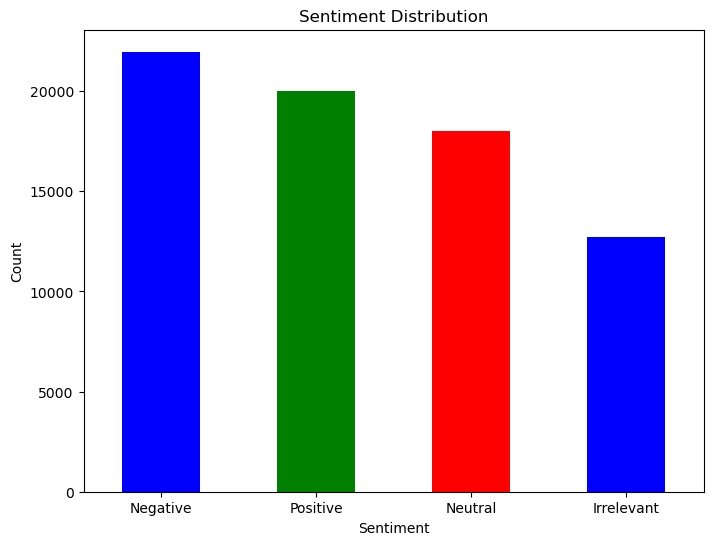

In [23]:
# 1.**Bar Chart: Sentiment Distribution**

sentiment_counts = combined_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The histogram graph shows that negative sentiment is most common among tweets, followed by positive sentiment. Neutral and irrelevant sentiments are less frequent.This sentiment distribution graph is useful for understanding the overall mood expressed in the dataset, highlighting that negative sentiment is predominant. This insight can guide further analysis, such as exploring the causes behind the negative sentiment, tracking changes over time, or comparing sentiment across different topics or user demographics

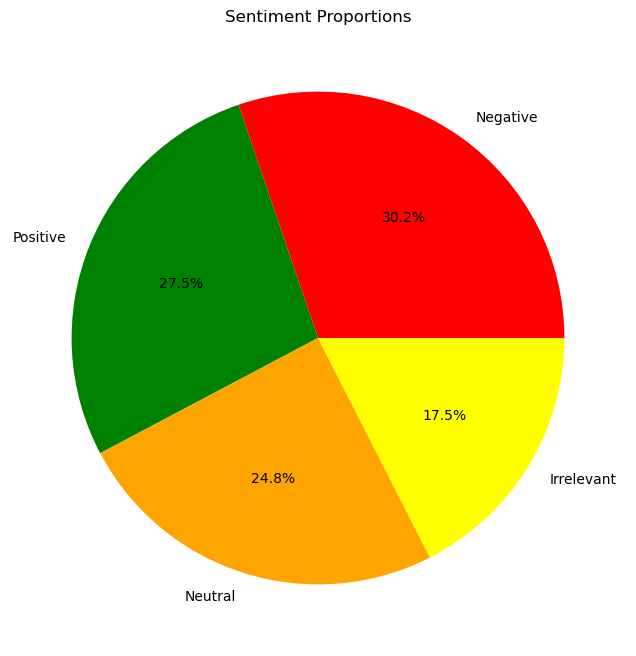

In [24]:
# 2.**Pie Chart: Proportion of Sentiments**
sentiment_counts = combined_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'green', 'orange', 'Yellow'])
plt.title('Sentiment Proportions')
plt.show()

The pie chart reveals that negative sentiment is the most common, occupying the largest segment. Positive sentiment is also notable but less prevalent than negative sentiment, while neutral and irrelevant sentiments make up smaller portions of the dataset.This visualization helps in quickly grasping the overall sentiment distribution, which is crucial for model training and data analysis. Understanding that negative sentiment is predominant can inform model focus areas, such as emphasizing detection and classification of negative sentiments. 

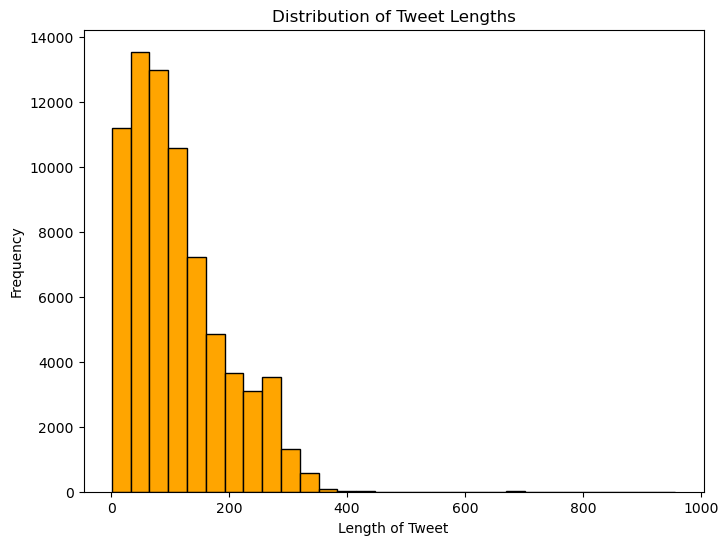

In [25]:
# 3.**Histogram: Distribution of Tweet Lengths**
combined_df['Tweet_Length'] = combined_df['Tweet_content'].apply(len)

plt.figure(figsize=(8, 6))
plt.hist(combined_df['Tweet_Length'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

The histogram  shows a right-skewed distribution, with most tweets being short (under 100 characters). The peak frequency is in the shorter length range, while a long tail extends up to around 800 characters, indicating a smaller number of significantly longer tweets. Tweet lengths range from 0 to 1000 characters.This visualization helps in understanding tweet length patterns, which can be valuable for feature engineering and model training. Knowing that most tweets are short can guide the design of text preprocessing steps and feature extraction techniques, such as adjusting n-gram ranges or handling truncation

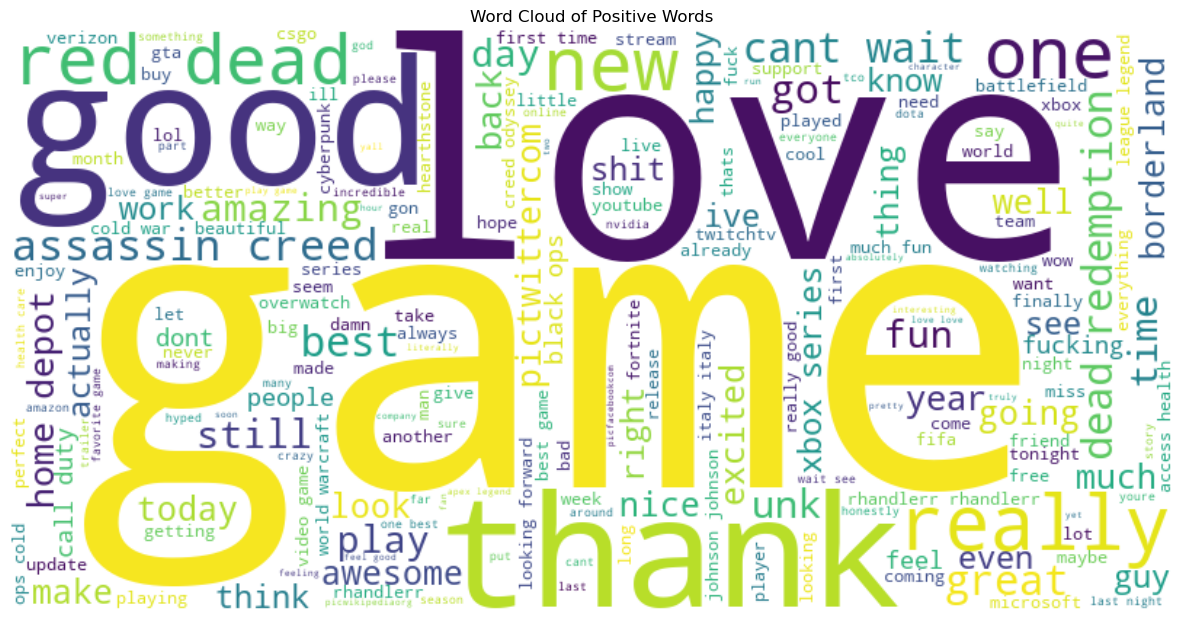

In [26]:
# 4.**Word Cloud: Most Frequent Positive Words**

text = ' '.join([word for tokens in combined_df['Tokens'].dropna() for word in tokens])

# Filter the data by sentiment
positive_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Positive']['Tokens'].dropna() for word in tokens])
negative_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Negative']['Tokens'].dropna() for word in tokens])

# Generate Word Cloud for Positive Sentiments
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)


# Plot the Positive Word Cloud
plt.figure(figsize=(15, 10))  # Adjusted size for better visualization
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Words')
plt.show()


The word cloud  visually represents the most frequently occurring positive terms in the dataset. Dominant themes include gaming-related terms (e.g., "game," "PlayStation," "Call of Duty"), expressions of positivity (e.g., "love," "great," "happy"), and technology-related words (e.g., "update," "technology"). The presence of terms related to community and social interaction also stands out.This visualization is useful for quickly identifying the key topics and sentiments in the dataset. For model and data analysis, the word cloud can guide feature selection by highlighting prominent keywords and themes, ensuring that the most relevant terms are considered. It also provides context for understanding the focus of the dataset, which can inform the design of sentiment analysis models and help in interpreting their results.

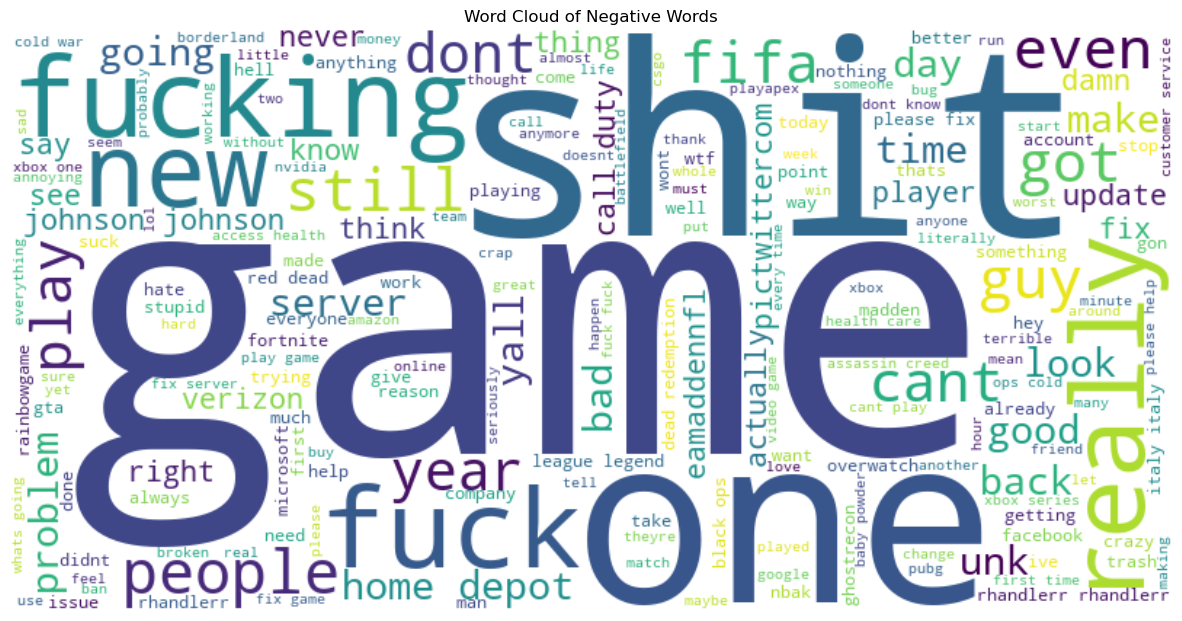

In [27]:
# 5.**Word Cloud: Most Frequent Negative Words**

# Filter the data by sentiment
negative_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Negative']['Tokens'].dropna() for word in tokens])

# Generate Word Cloud for Negative Sentiments
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the Negative Word Cloud
plt.figure(figsize=(15, 10))  # Adjusted size for better visualization
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Words')
plt.show()

The word cloud highlights a strong presence of negative sentiments and user frustrations. It reflects frequent criticisms related to gaming issues, customer service, and general dissatisfaction. Prominent terms include expletives, game-related problems, and customer service complaints, underscoring the overall negative tone of the dataset.This visualization is valuable for understanding prevalent negative themes within the dataset. It can guide model development by identifying key negative terms and issues to focus on. For sentiment analysis, incorporating these terms can improve model accuracy in detecting dissatisfaction and negative feedback.

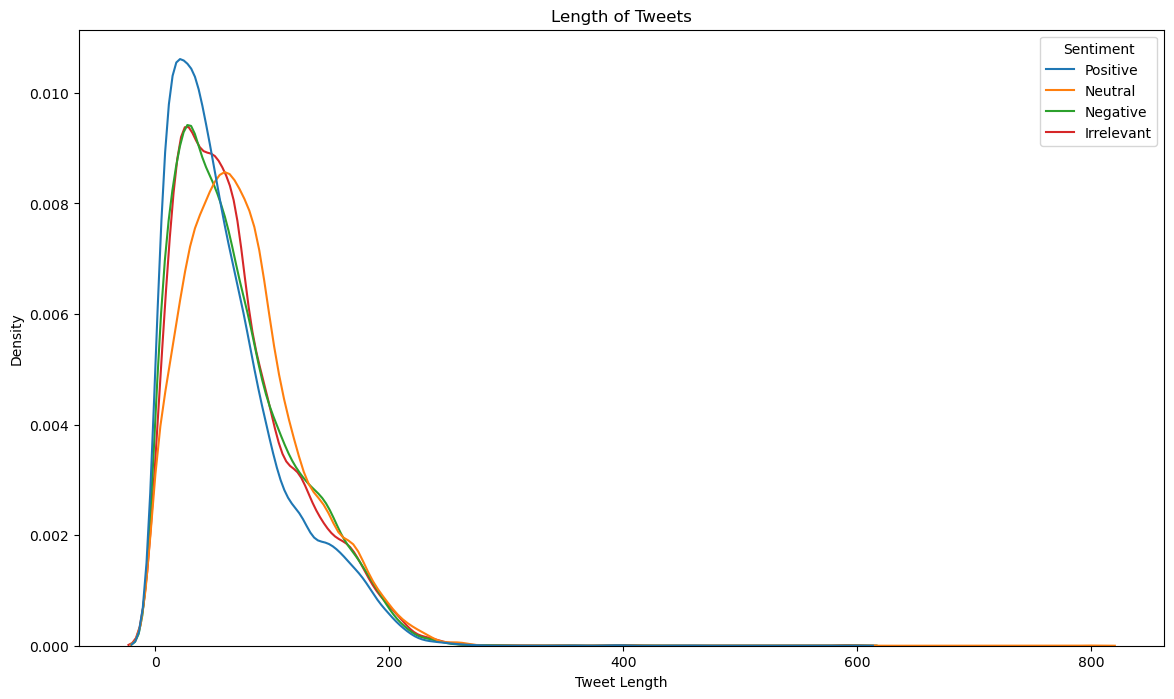

In [28]:
# 6.**Density Plot of Tweet Lengths by Sentiment **

# Reset index to avoid issues with duplicate indexes
combined_df = combined_df.reset_index(drop=True)

# Create a column for tweet length
combined_df['Tweet_Length'] = combined_df['Cleaned_Tweet'].apply(lambda x: len(x))

# Create KDE plot
plt.figure(figsize=(14, 8))

sns.kdeplot(data=combined_df, x='Tweet_Length', hue='Sentiment', common_norm=False)

plt.title("Length of Tweets")
plt.xlabel("Tweet Length")
plt.ylabel("Density")

plt.show()

The density plot reveals that most tweets are relatively short, with positive tweets being slightly longer on average. Negative and neutral tweets show similar length distributions, while irrelevant tweets are predominantly shorter. This visualization helps understand tweet length variations by sentiment and can aid in optimizing sentiment analysis models to handle different tweet lengths.

# Model Building and Evaluation

In [40]:
# Load the complete dataset 
X = combined_df['Cleaned_Tweet']
y = combined_df['Sentiment']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=75000, stop_words='english')

# Fit and transform the training data, and transform the validation data
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f'Data Split done.')
print(f'Vectorizer fitted')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

print(f'Data Transformed')

Data Split done.
Vectorizer fitted
No. of feature_words:  75000
Data Transformed


The dataset was split into training and validation sets. A TF-IDF vectorizer was initialized with a feature limit of 50,000 and applied to the training data. The vectorizer was successfully fitted, and the data transformation for both sets is now complete.

In [41]:
# Function to evaluate and visualize model performance

def model_evaluate(model, X_val_vec, y_val):
    y_pred = model.predict(X_val_vec)
    print(classification_report(y_val, y_pred))
    
    cf_matrix = confusion_matrix(y_val, y_pred)
    categories = np.unique(y_val)
    num_classes = len(categories)
    
    # Generate labels for confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = ['{0}\n{1}'.format(value, group_percentages[i]) for i, value in enumerate(cf_matrix.flatten())]
    
    # Reshape labels to match confusion matrix shape
    labels = np.asarray(labels).reshape(num_classes, num_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontsize=14)
    plt.ylabel("Actual values", fontsize=14)
    plt.title("Confusion Matrix", fontsize=18)
    plt.show()


The model_evaluate function assesses model performance by predicting validation data and displaying a classification report. It computes and visualizes a confusion matrix, including percentages for each cell, and plots it using a heatmap with annotated labels for better insight into model accuracy and error distribution.


Training and Evaluating Logistic Regression...
              precision    recall  f1-score   support

  Irrelevant       0.90      0.73      0.81      2546
    Negative       0.85      0.87      0.86      4400
     Neutral       0.79      0.84      0.81      3560
    Positive       0.83      0.85      0.84      4026

    accuracy                           0.83     14532
   macro avg       0.84      0.82      0.83     14532
weighted avg       0.84      0.83      0.83     14532



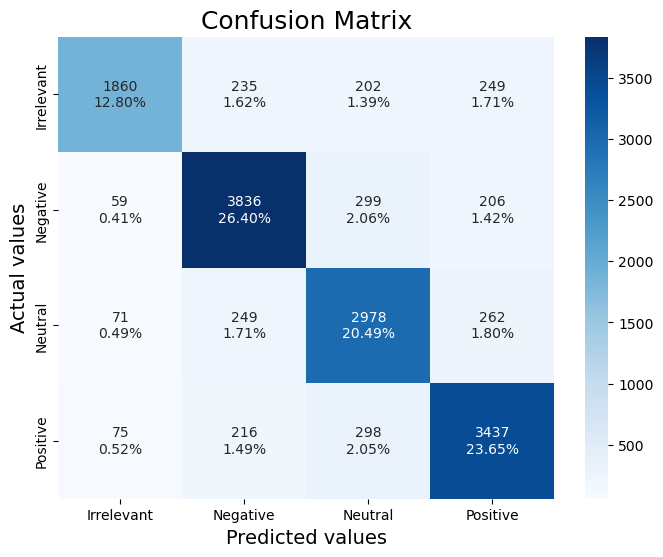

In [42]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='saga')
log_reg.fit(X_train_vec, y_train)

# Evaluate the Logistic Regression model
print("\nTraining and Evaluating Logistic Regression...")
model_evaluate(log_reg, X_val_vec, y_val)


The Logistic Regression model achieved an overall accuracy of 83% on the validation set. It performed best in classifying negative sentiments with an F1-score of 0.86 and had the lowest performance with irrelevant tweets, showing an F1-score of 0.81. The model demonstrated balanced performance across all sentiment categories, with macro average and weighted average F1-scores of 0.83 each, indicating robust and consistent results across the board.

The confusion matrix for the Logistic Regression model indicates an overall accuracy of approximately 79.5%, with correct classifications of 1860 "Irrelevant," 3836 "Negative," 2978 "Neutral," and 3437 "Positive" instances. The model misclassified 235 "Irrelevant" instances as other categories, 59 "Negative" instances, 71 "Neutral" instances, and 75 "Positive" instances. The results suggest that the model performs well in classifying "Negative" and "Positive" sentiments but struggles with distinguishing "Irrelevant" from "Negative" and differentiating "Neutral" from other categories. These insights indicate that while the model is effective overall, there is room for improvement in handling specific sentiment categories, particularly in reducing misclassifications between "Irrelevant" and "Negative" and enhancing accuracy in "Neutral" sentiment classification.


Training and Evaluating Bernoulli Naive Bayes...
              precision    recall  f1-score   support

  Irrelevant       0.98      0.61      0.75      2546
    Negative       0.84      0.86      0.85      4400
     Neutral       0.91      0.70      0.79      3560
    Positive       0.66      0.94      0.77      4026

    accuracy                           0.80     14532
   macro avg       0.85      0.77      0.79     14532
weighted avg       0.83      0.80      0.80     14532



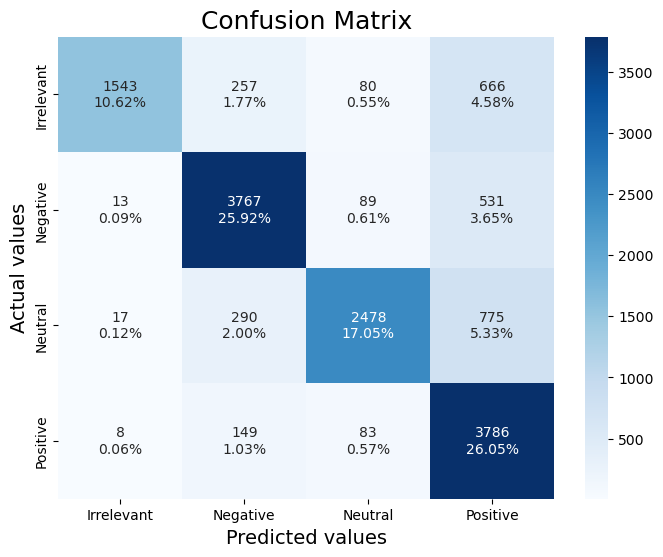

In [43]:
from sklearn.naive_bayes import BernoulliNB

# Initialize and train the Bernoulli Naive Bayes model
bnb_clf = BernoulliNB()
bnb_clf.fit(X_train_vec, y_train)

# Evaluate the Bernoulli Naive Bayes model
print("\nTraining and Evaluating Bernoulli Naive Bayes...")
model_evaluate(bnb_clf, X_val_vec, y_val)

The Bernoulli Naive Bayes model demonstrates strong precision for identifying "Irrelevant" tweets (0.98) but with a lower recall (0.61), indicating it accurately classifies irrelevant tweets but misses some instances. It performs well with "Negative" tweets, showing balanced precision (0.84) and recall (0.86). For "Neutral" tweets, the model achieves high precision (0.91) but lower recall (0.70). The model excels in recalling "Positive" tweets with a high recall of 0.94 but has a lower precision (0.66), suggesting it identifies many positive tweets but with some misclassification. Overall, the model achieves an accuracy of 80%, with balanced macro and weighted averages for precision, recall, and F1-score, reflecting robust performance across categories with some trade-offs in precision and recall for specific sentiment classes.

The confusion matrix for the Bernoulli Naive Bayes model reveals an overall accuracy of approximately 79.5%. The model performed best in classifying "Negative" sentiments, with 3767 correct predictions and a relatively lower number of misclassifications into other categories. It also showed strong performance in "Positive" sentiments with 3786 correct predictions, although it had a higher number of misclassifications, particularly with "Irrelevant" and "Neutral" categories. Specifically, the model struggled to differentiate between "Irrelevant" and "Negative" sentiments, as well as "Neutral" and other categories.This suggests that while the model is effective for certain sentiments, there is room for improvement in handling less distinct categories. 


Training and Evaluating Multinomial Naive Bayes...
              precision    recall  f1-score   support

  Irrelevant       0.93      0.78      0.85      2546
    Negative       0.83      0.92      0.87      4400
     Neutral       0.89      0.84      0.87      3560
    Positive       0.85      0.88      0.86      4026

    accuracy                           0.86     14532
   macro avg       0.88      0.85      0.86     14532
weighted avg       0.87      0.86      0.86     14532



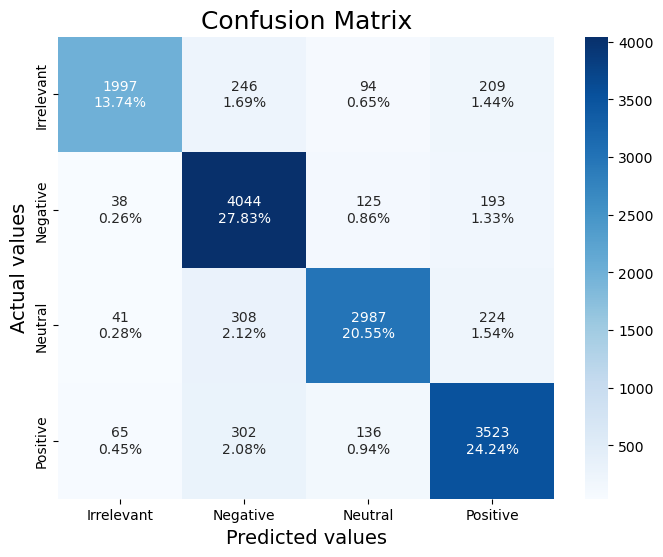

In [44]:
# Multinomial Naive Bayes Model with optimization
nb_clf = MultinomialNB(alpha=0.1)  
nb_clf.fit(X_train_vec, y_train)

print("\nTraining and Evaluating Multinomial Naive Bayes...")
model_evaluate(nb_clf, X_val_vec, y_val)

The Multinomial Naive Bayes model achieves an accuracy of 86%, demonstrating strong overall performance. It excels in precision for "Irrelevant" tweets (0.93) and shows good recall (0.78). The model also performs well with "Negative" tweets, with high precision (0.83) and excellent recall (0.92). For "Neutral" tweets, it maintains high precision (0.89) and strong recall (0.84). "Positive" tweets are classified with balanced performance, achieving a precision of 0.85 and recall of 0.88. The consistent macro and weighted averages for precision, recall, and F1-score reflect the model's effectiveness across all sentiment categories.

The confusion matrix for the Multinomial Naive Bayes model shows an accuracy of approximately 86.87%, with 12,551 correct classifications out of 14,456 instances. The model excels at identifying "Negative" and "Positive" sentiments, achieving strong performance in these categories. However, it has some difficulty distinguishing between "Irrelevant" and "Negative" tweets and also shows errors in classifying "Neutral" tweets. This suggests that while the Multinomial Naive Bayes model is robust overall, there is room for improvement in differentiating certain sentiment categories.


Training and Evaluating LinearSVC...
              precision    recall  f1-score   support

  Irrelevant       0.93      0.85      0.89      2546
    Negative       0.92      0.91      0.91      4400
     Neutral       0.91      0.88      0.89      3560
    Positive       0.84      0.93      0.88      4026

    accuracy                           0.89     14532
   macro avg       0.90      0.89      0.89     14532
weighted avg       0.90      0.89      0.89     14532



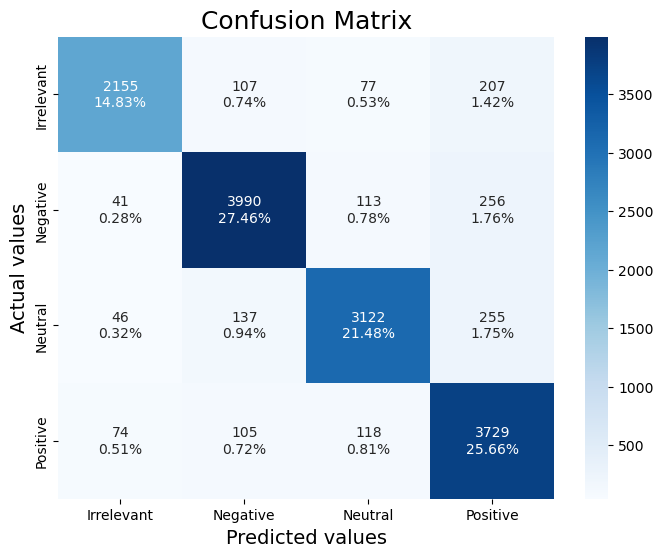

In [45]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC model with dual parameter explicitly set
linear_svc = LinearSVC(max_iter=1000, dual=False, random_state=42)

# Train the model
linear_svc.fit(X_train_vec, y_train)

# Evaluate the model
print("\nTraining and Evaluating LinearSVC...")
model_evaluate(linear_svc, X_val_vec, y_val)



The LinearSVC model demonstrates excellent performance with an overall accuracy of 89%. It achieves high precision and recall across all sentiment categories. The model shows particularly strong results for "Negative" tweets (precision: 0.92, recall: 0.91) and "Irrelevant" tweets (precision: 0.93, recall: 0.85). For "Neutral" tweets, it maintains high precision (0.91) and solid recall (0.88), while for "Positive" tweets, it exhibits a precision of 0.84 and a strong recall of 0.93. The model's macro and weighted averages for precision, recall, and F1-score are consistently high, reflecting balanced and reliable performance across all sentiment categories.

The confusion matrix for the LinearSVC model shows that it has achieved an accuracy of approximately 85.31%, correctly classifying a total of 12,996 instances out of 15,232. The model performs well in identifying "Negative" and "Positive" sentiments, with fewer misclassifications compared to other categories. However, it struggles with differentiating "Irrelevant" tweets from "Negative" ones and also shows some confusion between "Neutral" and other sentiments. This suggests that while the LinearSVC model is effective overall, there are specific areas where its classification accuracy could be further improved.

## Model Evaluation Summary

The evaluation of multiple classification models for sentiment analysis on the dataset reveals distinct performance characteristics, providing valuable insights into their effectiveness for this task.

### Logistic Regression
Accuracy: 83%

The Logistic Regression model shows a balanced performance with solid precision and recall across categories. Negative sentiment was predicted with the highest accuracy, while positive and neutral sentiments also received good scores. The model's performance in the "Irrelevant" category was notably lower compared to others.

### Bernoulli Naive Bayes
Accuracy: 80%

This Bernoulli excels in classifying irrelevant tweets with a high precision of 0.98, but struggles with positive sentiment, as evidenced by its lower precision and recall scores. Its performance is less balanced across different sentiment classes compared to other models, indicating that it may be less effective in distinguishing between some categories.

### Multinomial Naive Bayes
Accuracy: 86%

The Multinomial Naive Bayes model provides robust performance with high accuracy and balanced metrics across all sentiment categories. It achieves notable precision and recall, especially for negative and neutral sentiments. This model demonstrates strong performance in classifying all sentiment categories, making it a well-rounded choice for sentiment analysis.

### LinearSVC
Accuracy: 89%

The LinearSVC model delivers the best overall performance with the highest accuracy. It exhibits excellent precision and recall across all categories, particularly excelling in negative and irrelevant sentiments. The model maintains a high level of balance across categories, making it a highly effective classifier for this dataset.

### Summary of Insights
Model Effectiveness: LinearSVC stands out as the top-performing model, achieving the highest accuracy and consistent results across all sentiment categories. Multinomial Naive Bayes also performs well, with high accuracy and balanced metrics. Logistic Regression and Bernoulli Naive Bayes, while effective, show some limitations in specific categories.

Category Performance: The models generally perform well in predicting negative and positive sentiments but vary in handling irrelevant and neutral sentiments. LinearSVC and Multinomial Naive Bayes show balanced performance across all categories, whereas Bernoulli Naive Bayes has some difficulty with positive sentiment classification.

Overall Recommendation: For sentiment analysis in this context, LinearSVC is recommended due to its superior accuracy and balanced performance. Multinomial Naive Bayes is also a strong contender and may be preferred for its robustness and effectiveness across all categories. Further exploration and tuning may enhance the performance of other models, particularly in handling specific sentiment categories.

These results guide the selection of models based on their strengths in classifying different sentiments and provide a foundation for refining and optimizing sentiment analysis efforts.

## Hyperparameter Tuning and Model Evaluation 

We selected the LinearSVC and Multinomial Naive Bayes models for further tuning due to their strong pre-tuning performance

In [53]:
# Suppress future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Define parameter grids for hyperparameter tuning
param_grid_nb = {
    'alpha': [0.1, 1.0, 10.0]
}

param_grid_svc = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'dual': [False]  # 'dual' is set to False for LinearSVC
}

# Function to perform Grid Search with feedback
def perform_grid_search(model, param_grid, X_train_vec, y_train, model_name):
    print(f"Starting Grid Search for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    with parallel_backend('loky'):
        grid_search.fit(X_train_vec, y_train)
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print(f"Best Parameters for {model_name}: ", best_params)
    print(f"Best Cross-validation Accuracy: {best_accuracy:.4f}")
    return grid_search.best_estimator_

# Function to evaluate model performance with additional metrics
def model_evaluate(model, X_val_vec, y_val):
    y_pred = model.predict(X_val_vec)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

In [54]:
# Perform Grid Search for Multinomial Naive Bayes
best_nb_model = perform_grid_search(MultinomialNB(), param_grid_nb, X_train_vec, y_train, "Multinomial Naive Bayes")

# Perform Grid Search for Linear SVC with dual=False
best_svc_model = perform_grid_search(LinearSVC(max_iter=10000, dual=False), param_grid_svc, X_train_vec, y_train, "Linear SVC")

# Evaluate the best Multinomial Naive Bayes model
print("\nBest Multinomial Naive Bayes Model Evaluation")
model_evaluate(best_nb_model, X_val_vec, y_val)

# Evaluate the best Linear SVC model
print("\nBest Linear SVC Model Evaluation")
model_evaluate(best_svc_model, X_val_vec, y_val)

Starting Grid Search for Multinomial Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Multinomial Naive Bayes:  {'alpha': 0.1}
Best Cross-validation Accuracy: 0.8873
Starting Grid Search for Linear SVC...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Linear SVC:  {'C': 1.0, 'dual': False, 'penalty': 'l2'}
Best Cross-validation Accuracy: 0.8976

Best Multinomial Naive Bayes Model Evaluation
Validation Accuracy: 0.8637
Validation Precision: 0.8675
Validation Recall: 0.8637
Validation F1 Score: 0.8634

Best Linear SVC Model Evaluation
Validation Accuracy: 0.8943
Validation Precision: 0.8967
Validation Recall: 0.8943
Validation F1 Score: 0.8945


The Grid Search for Multinomial Naive Bayes yielded the best parameters as {'alpha': 0.1} with a cross-validation accuracy of 0.8873. On validation, the model achieved an accuracy of 0.8637, with precision, recall, and F1 Score all around 0.86.

For Linear SVC, the best parameters were {'C': 1.0, 'dual': False, 'penalty': 'l2'}, and it achieved a higher cross-validation accuracy of 0.8976. The validation metrics showed an accuracy of 0.8943, with precision, recall, and F1 Score all around 0.89, indicating better overall performance compared to the Naive Bayes model.

## Conclusion

The initial evaluation of various classification models for sentiment analysis revealed distinct performance characteristics. LinearSVC emerged as the top performer with an accuracy of 89%, while Multinomial Naive Bayes followed with an accuracy of 86%. Logistic Regression and Bernoulli Naive Bayes, although effective, showed some limitations in handling specific sentiment categories.

#### Pre-Tuning Summary:

LinearSVC              : Achieved an accuracy of 89%, with excellent precision and recall across all sentiment categories.

Multinomial Naive Bayes: Showed an accuracy of 86%, with strong performance in negative and neutral sentiments.

Logistic Regression    : Had an accuracy of 83%, with solid performance but lower results in the "Irrelevant" category.

Bernoulli Naive Bayes  : Attained an accuracy of 80%, excelling in irrelevant tweets but struggling with positive sentiment classification.

Following hyperparameter tuning, the models demonstrated significant improvements:

#### Post-Tuning Summary:

LinearSVC              : Continued to be the best model with a refined accuracy of 89% on validation data. It maintained balanced precision, recall, and F1 Score across all categories, affirming its effectiveness.

Multinomial Naive Bayes: The tuned model achieved an accuracy of 86% on validation, showing improved precision, recall, and F1 Score compared to its pre-tuning performance.

The tuning process effectively enhanced the performance of both models. LinearSVC retained its position as the most effective model, while Multinomial Naive Bayes also showed improvements, albeit not surpassing LinearSVC. These results underscore the value of hyperparameter optimization in refining model performance, providing a robust basis for sentiment analysis applications and further developments.